In [57]:
# read three pkl files and combine them into one
import pickle
import pandas as pd
with open('/home/nele_pauline_suffo/ProcessedData/annotations_superannotate/quantex_share_annotations_1a.pkl', 'rb') as f:
    annotations_1a = pickle.load(f)

with open('/home/nele_pauline_suffo/ProcessedData/annotations_superannotate/quantex_share_annotations_1b.pkl', 'rb') as f:
    annotations_1b = pickle.load(f)

with open('/home/nele_pauline_suffo/ProcessedData/annotations_superannotate/quantex_share_annotations_dr.pkl', 'rb') as f:
    annotations_dr = pickle.load(f)

# Combine the dataframes
combined_df = pd.concat([annotations_1a, annotations_1b, annotations_dr])

# Store the combined dataframe into a new pickle file
combined_df.to_pickle('/home/nele_pauline_suffo/ProcessedData/annotations_superannotate/quantex_share_annotations.pkl')


In [58]:
# load df from pickle file
import pandas as pd
vtc_share_output = pd.read_pickle('/home/nele_pauline_suffo/outputs/vtc/quantex_share_vtc_output.pkl')
annotations_output = pd.read_pickle('/home/nele_pauline_suffo/ProcessedData/annotations_superannotate/quantex_share_annotations.pkl')

In [68]:
small_annotation = annotations_output[annotations_output['audio_file_name'] == '442279'].head(23)
small_annotation

,audio_file_name,Utterance_Start,Utterance_Duration,Voice_type,Utterance_End
0,442279,0.942,1.243,FEM,2.185
1,442279,0.942,1.243,SPEECH,2.185
2,442279,2.245,1.129,KCHI,3.374
3,442279,2.245,1.129,SPEECH,3.374
4,442279,3.714,1.919,FEM,5.633
5,442279,3.714,1.919,SPEECH,5.633
6,442279,5.650,3.044,KCHI,8.694
7,442279,5.650,3.044,SPEECH,8.694
8,442279,8.829,1.184,FEM,10.013
9,442279,8.829,1.184,SPEECH,10.013


In [73]:
small_sample = vtc_share_output[vtc_share_output['audio_file_name'] == '442279'].head(34)
small_sample

,audio_file_name,Utterance_Start,Utterance_Duration,Voice_type,Utterance_End
85936,442279,0.511,2.803,SPEECH,3.314
85937,442279,0.540,1.537,FEM,2.077
85938,442279,2.170,1.067,KCHI,3.237
85939,442279,3.544,2.850,SPEECH,6.394
85940,442279,3.552,1.957,FEM,5.509
85941,442279,5.495,0.852,KCHI,6.347
85942,442279,6.669,3.971,SPEECH,10.640
85943,442279,6.679,1.924,KCHI,8.603
85944,442279,8.746,1.632,FEM,10.378
85945,442279,8.824,0.407,MAL,9.231


(0.0, 30.0)

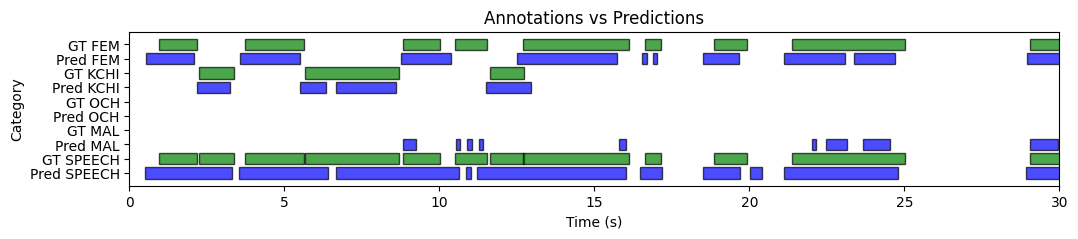

In [67]:
import matplotlib.pyplot as plt

# Set up the figure and axis
plt.figure(figsize=(12, 2))
ax = plt.gca()

ground_truth_fem = small_annotation[small_annotation['Voice_type'] == 'FEM']
ground_truth_mal = small_annotation[small_annotation['Voice_type'] == 'MAL']
ground_truth_kchi = small_annotation[small_annotation['Voice_type'] == 'KCHI']
ground_truth_och = small_annotation[small_annotation['Voice_type'] == 'OCH']
ground_truth_speech = small_annotation[small_annotation['Voice_type'] == 'SPEECH']
predictions_fem = small_sample[small_sample['Voice_type'] == 'FEM']
predictions_mal = small_sample[small_sample['Voice_type'] == 'MAL']
predictions_kchi = small_sample[small_sample['Voice_type'] == 'KCHI']
predictions_och = small_sample[small_sample['Voice_type'] == 'OCH']
predictions_speech = small_sample[small_sample['Voice_type'] == 'SPEECH']

# Define y-positions for the two bars
y_ground_truth_fem = 9
y_predictions_fem = 8 

y_ground_truth_kchi = 7
y_predictions_kchi = 6 

y_ground_truth_och = 5
y_predictions_och = 4 

y_ground_truth_mal = 3
y_predictions_mal = 2

y_ground_truth_speech = 1
y_predictions_speech = 0

# Plot predictions, excluding SPEECH
for idx, row in predictions_fem.iterrows():
    ax.barh(y_predictions_fem, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

for idx, row in predictions_mal.iterrows():
    ax.barh(y_predictions_mal, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

for idx, row in predictions_kchi.iterrows():
    ax.barh(y_predictions_kchi, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

for idx, row in predictions_och.iterrows():
    ax.barh(y_predictions_och, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

for idx, row in predictions_speech.iterrows():
    ax.barh(y_predictions_speech, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)
    
for idx, row in ground_truth_fem.iterrows():
    ax.barh(y_ground_truth_fem, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)
    
for idx, row in ground_truth_mal.iterrows():
    ax.barh(y_ground_truth_mal, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)

for idx, row in ground_truth_kchi.iterrows():
    ax.barh(y_ground_truth_kchi, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)
    
for idx, row in ground_truth_och.iterrows():
    ax.barh(y_ground_truth_och, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)
    
for idx, row in ground_truth_speech.iterrows():
    ax.barh(y_ground_truth_speech, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)
    
    

# Adjust y-axis ticks and labels
ax.set_yticks([y_ground_truth_speech, y_predictions_speech, y_ground_truth_fem, y_predictions_fem, y_ground_truth_mal, y_predictions_mal, y_ground_truth_kchi, y_predictions_kchi, y_ground_truth_och, y_predictions_och])
ax.set_yticklabels(["GT SPEECH", "Pred SPEECH", "GT FEM", "Pred FEM", "GT MAL", "Pred MAL", "GT KCHI", "Pred KCHI", "GT OCH", "Pred OCH"])

# Add labels and titles
ax.set_xlabel("Time (s)")
ax.set_ylabel("Category")
ax.set_title("Annotations vs Predictions")
ax.set_xlim(0, 30)

(0.0, 30.0)

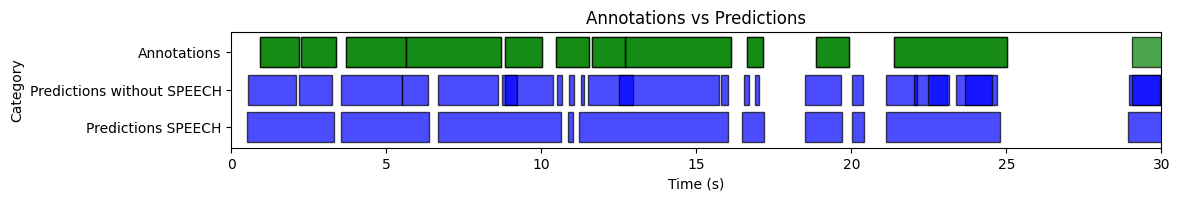

In [74]:
import matplotlib.pyplot as plt

# Set up the figure and axis
plt.figure(figsize=(12, 1.5))
ax = plt.gca()

ground_truth = small_annotation[small_annotation['audio_file_name'] == '442279'].head(25)
predictions_fem = small_sample[small_sample['Voice_type'] == 'FEM']
predictions_mal = small_sample[small_sample['Voice_type'] == 'MAL']
predictions_kchi = small_sample[small_sample['Voice_type'] == 'KCHI']
predictions_och = small_sample[small_sample['Voice_type'] == 'OCH']
predictions_speech = small_sample[small_sample['Voice_type'] == 'SPEECH']
predictions_without_speech = small_sample[small_sample['Voice_type'] != 'SPEECH']

# Define y-positions for the two bars
y_annotations = 2  # Position for "Annotations"
y_predictions_1 = 1  # Position for "Predictions"
y_predictions_2 = 0  # Position for "Predictions"

# Plot each annotation as a bar
for idx, row in ground_truth.iterrows():
    ax.barh(y_annotations, row['Utterance_Duration'], left=row['Utterance_Start'], color='green', edgecolor='black', alpha=0.7)

# Plot predictions, excluding SPEECH
for idx, row in predictions_without_speech.iterrows():
    ax.barh(y_predictions_1, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

# Plot predictions, including SPEECH
for idx, row in predictions_speech.iterrows():
    ax.barh(y_predictions_2, row['Utterance_Duration'], left=row['Utterance_Start'], color='blue', edgecolor='black', alpha=0.7)

# Adjust y-axis ticks and labels
ax.set_yticks([y_predictions_2,y_predictions_1, y_annotations])
ax.set_yticklabels(["Predictions SPEECH", "Predictions without SPEECH", "Annotations"])

# Add labels and titles
ax.set_xlabel("Time (s)")
ax.set_ylabel("Category")
ax.set_title("Annotations vs Predictions")
ax.set_xlim(0, 30)

In [ ]:
import pandas as pd
from pyannote.metrics.detection import DetectionPrecisionRecallFMeasure
from pyannote.core import Annotation, Segment

def dataframe_to_annotation(df, label_column="Voice_type"):
    """
    Converts a DataFrame to a pyannote.core.Annotation object.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with 'Utterance_Start', 'Utterance_End', and a label column.
    - label_column (str): Column name for the labels (default: 'Voice_type').

    Returns:
    - Annotation: pyannote.core.Annotation object.
    """
    annotation = Annotation()
    for _, row in df.iterrows():
        start = float(row["Utterance_Start"])
        end = float(row["Utterance_End"])
        label = row[label_column]
        print(label)
        annotation[Segment(start, end)] = label
    return annotation

reference_df = pd.read_pickle('/home/nele_pauline_suffo/ProcessedData/annotations_superannotate/quantex_share_annotations.pkl')
reference = dataframe_to_annotation(reference_df[0:10])

print(reference_df[0:10])
print(reference)

  audio_file_name  Utterance_Start  Utterance_Duration Voice_type  \
0          183537            1.771              27.021        FEM   
1          183537            1.771              27.021     SPEECH   
2          183537           29.167               5.671       KCHI   
3          183537           29.167               5.671     SPEECH   
4          183537           38.049              29.523       KCHI   
5          183537           38.049              29.523     SPEECH   
6          183537           80.354              31.203       KCHI   
7          183537           80.354              31.203     SPEECH   
8          183537          282.308               1.872       KCHI   
9          183537          282.308               1.872     SPEECH   

   Utterance_End  
0         28.792  
1         28.792  
2         34.838  
3         34.838  
4         67.572  
5         67.572  
6        111.557  
7        111.557  
8        284.180  
9        284.180  
[ 00:00:01.771 -->  00:00:28.79